In [8]:

import re
import os
import sys
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import networkx as nx
import pybedtools as bt
from scipy import stats

import matplotlib.patches as mpatches
import matplotlib.collections as mcol

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.offsetbox import AnchoredText

from matplotlib import gridspec
from matplotlib.lines import Line2D
from mycolorpy import colorlist as mcp

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

color1=mcp.gen_color(cmap="Reds",n=10)[-7:-2]
color2=mcp.gen_color(cmap="Greys",n=10)[-5:]
color3=mcp.gen_color(cmap="Blues",n=10)[-5:]
color4=mcp.gen_color(cmap="Greens",n=10)[-5:]
H = pickle.load( open('../January-23/data/G_ALL.p', 'rb'))
MAPty = pickle.load(open('../January-23/data/MAPty.p', 'rb'))
MAPcl = pickle.load(open('../January-23/data/MAPcl.p', 'rb'))
MAPgn = pickle.load(open('../July-23/data/MAPgn.p', 'rb'))
sns.set(style="ticks", font_scale=2)

In [2]:

    
BEDPES_H3K27ac = {}
for i, h in  enumerate(["Vh", "30m","4h", "16h", "72h"]):
    BEDPES_H3K27ac[h] = bt.BedTool(f"../January-23/data/ALL_H3K27ac_{h}.tmm.bedpe")

BEDPES_H3K4me3 = {}
for i, h in  enumerate(["Vh", "30m","4h", "16h", "72h"]):
    BEDPES_H3K4me3[h] = bt.BedTool(f"../January-23/data/ALL_H3K4me3_{h}.tmm.bedpe")
    
    

In [3]:
BEDPRO = pd.read_table('../June-23/BEDPRO_new.tsv')
#BEDPRO
#BEDPRO[BEDPRO['Gene'] == 'FKBP5']


n = pd.read_table('../June-23/tmm.start.tsv').set_index('Gene')
times = ['Vh', '30m', '4h', '16h', '72h']

m = pd.concat((n[['R1_Vh', 'R2_Vh']].mean(1), n[['R1_30m', 'R2_30m']].mean(1), n[['R1_4h', 'R2_4h']].mean(1), n[['R1_16h', 'R2_16h']].mean(1), n[['R1_72h', 'R2_72h']].mean(1)), 1)


for i,t in enumerate(times):
	mapr = dict(zip(m.index, m[i]))
	BEDPRO[f'START_{times[i]}'] = BEDPRO['Gene'].map(mapr)

BEDPRO = BEDPRO[~BEDPRO['START_Vh'].isna()]


/tmp/ipykernel_186724/1219712933.py:9: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  m = pd.concat((n[['R1_Vh', 'R2_Vh']].mean(1), n[['R1_30m', 'R2_30m']].mean(1), n[['R1_4h', 'R2_4h']].mean(1), n[['R1_16h', 'R2_16h']].mean(1), n[['R1_72h', 'R2_72h']].mean(1)), 1)


In [4]:

for t in ['30m', '4h', '16h', '72h']:
	BEDPRO[f'S_{t}'] = 0
	BEDPRO.loc[np.log2((BEDPRO[f'START_{t}']+1) / (BEDPRO['START_Vh']+1)) > 1, f'S_{t}'] = 1
	BEDPRO.loc[np.log2((BEDPRO[f'START_{t}']+1) / (BEDPRO['START_Vh']+1)) < -1, f'S_{t}'] = -1
Counter(BEDPRO['S_16h'])

Counter({0: 10555, -1: 273, 1: 250})

In [5]:
tmp = BEDPRO[(BEDPRO[['S_30m', 'S_4h', 'S_16h', 'S_72h']] == 1).sum(1) != 0]
genes = np.array(tmp['Name'])

s = tmp[['START_Vh', 'START_30m', 'START_4h','START_16h','START_72h']].T.values
z = ((s - s.mean(0)) / s.std(0)).T

clss = z.argmax(1)
Counter(clss)

Counter({1: 69, 4: 137, 2: 102, 3: 209})

In [1]:
69 + 137 + 102 + 209

517

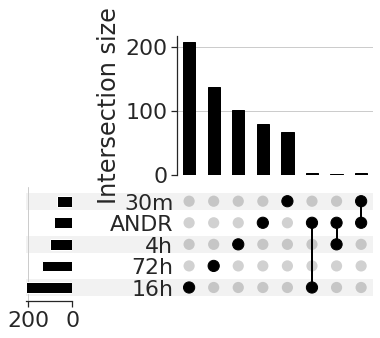

In [6]:
cl1 = genes[clss == 1]
cl2 = genes[clss == 2]
cl3 = genes[clss == 3]
cl4 = genes[clss == 4]
high = np.random.choice(BEDPRO.loc[((BEDPRO[['S_16h','S_30m','S_4h','S_72h']] == 0).sum(1) == 4) & (BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=200)


andr = set(BEDPRO.loc[BEDPRO['Quartile'] == 'ANDR', 'Name'].tolist())
cl1 = set(genes[clss == 1])
cl2 = set(genes[clss == 2])
cl3 = set(genes[clss == 3])
cl4 = set(genes[clss == 4])


from upsetplot import from_contents,UpSet

genes = from_contents({'30m': cl1, '4h': cl2, '16h':cl3, '72h': cl4, 'ANDR': andr})
ax_dict = UpSet(genes, subset_size='count').plot()


In [11]:
[MAPgn[g] for g in cl3 if MAPgn[g] in ['KLK3', 'KLK2'] ], [MAPgn[g] for g in cl2 if MAPgn[g] in ['KLK3', 'KLK2'] ]

(['KLK2'], ['KLK3'])

In [8]:

def calculateC_enhancer(geneset, s,  to):
	global MAPcl
	global H
	I = {
		n:list(nx.bfs_layers(H, n))[1]
		for n in geneset
		if n in H
		if len(list(nx.bfs_layers(H, n))) > 1
	}

	A = []
	for p,es in I.items():
		for e in es:
			if MAPcl[e] == to:
				d = H.get_edge_data(p, e)
				l = [d[k] for k in [f"{s}.Vh",f"{s}.30m",f"{s}.4h", f"{s}.16h", f"{s}.72h"]]

				A += [l]

	c1 = pd.DataFrame(np.array(A), columns=["Vh", "30m","4h", "16h", "72h"])
	return c1





In [9]:

c1 = calculateC_enhancer(cl1, 'H3K27ac',  'ARcre')
c2 = calculateC_enhancer(cl2, 'H3K27ac',  'ARcre')
c3 = calculateC_enhancer(cl3, 'H3K27ac',  'ARcre')
c4 = calculateC_enhancer(cl4, 'H3K27ac',  'ARcre')
hh = calculateC_enhancer(high, 'H3K27ac',  'ARcre')


BOOT = 1000
FC1_H3K27ac = np.zeros((BOOT, 5))
FC2_H3K27ac = np.zeros((BOOT, 5))
FC3_H3K27ac = np.zeros((BOOT, 5))
FC4_H3K27ac = np.zeros((BOOT, 5))
FC5_H3K27ac = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[((BEDPRO[['S_16h','S_30m','S_4h','S_72h']] == 0).sum(1) == 4) & (BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=200)
    tmp = calculateC_enhancer(geneset, 'H3K27ac',  'cre')

    FC1_H3K27ac[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K27ac[i,:] = c2.mean(0) / tmp.mean(0)
    FC3_H3K27ac[i,:] = c3.mean(0) / tmp.mean(0)
    FC4_H3K27ac[i,:] = c4.mean(0) / tmp.mean(0)
    FC5_H3K27ac[i,:] = hh.mean(0) / tmp.mean(0)        
            
            
            
   


In [10]:

c1 = calculateC_enhancer(cl1, 'H3K4me3',  'ARcre')
c2 = calculateC_enhancer(cl2, 'H3K4me3',  'ARcre')
c3 = calculateC_enhancer(cl3, 'H3K4me3',  'ARcre')
c4 = calculateC_enhancer(cl4, 'H3K4me3',  'ARcre')
hh = calculateC_enhancer(high, 'H3K4me3',  'ARcre')


BOOT = 1000
FC1_H3K4me3 = np.zeros((BOOT, 5))
FC2_H3K4me3 = np.zeros((BOOT, 5))
FC3_H3K4me3 = np.zeros((BOOT, 5))
FC4_H3K4me3 = np.zeros((BOOT, 5))
FC5_H3K4me3 = np.zeros((BOOT, 5))
#for j, s in enumerate(['H3K27ac', 'H3K4me3']):
####################################
np.random.seed(7)
for i in range(BOOT):
    geneset = np.random.choice(BEDPRO.loc[((BEDPRO[['S_16h','S_30m','S_4h','S_72h']] == 0).sum(1) == 4) & (BEDPRO['Quartile'] == 'High'), 'Name'].tolist(), size=200)
    tmp = calculateC_enhancer(geneset, 'H3K4me3',  'cre')

    FC1_H3K4me3[i,:] = c1.mean(0) / tmp.mean(0) 
    FC2_H3K4me3[i,:] = c2.mean(0) / tmp.mean(0)
    FC3_H3K4me3[i,:] = c3.mean(0) / tmp.mean(0)
    FC4_H3K4me3[i,:] = c4.mean(0) / tmp.mean(0)
    FC5_H3K4me3[i,:] = hh.mean(0) / tmp.mean(0)        
            
            
            
   


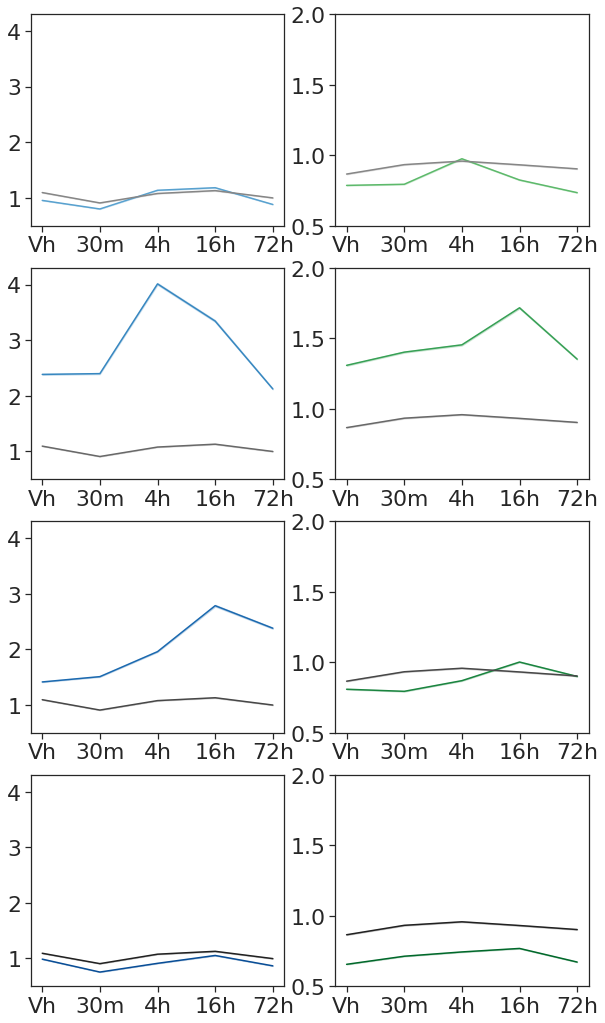

In [14]:
color1 = ['#F6C0C0', '#ED8080' , '#DA0000', '#6D0000'] 
color1 = ['#FCE4C8', '#F8C991', '#F19323', '#794A12']

fig = plt.figure(figsize=[10,20])
gs = gridspec.GridSpec(nrows=4, ncols=2, top=0.8)

fig.add_subplot(gs[0,0])
tmp1 = pd.DataFrame(np.array(FC1_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color3[0])

tmp5 = pd.DataFrame(np.array(FC5_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[0])

plt.ylim(0.5,4.3)
plt.xlabel('')
plt.ylabel('')

fig.add_subplot(gs[0,1])
tmp1 = pd.DataFrame(np.array(FC1_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color4[0])

tmp5 = pd.DataFrame(np.array(FC5_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[0])

plt.ylim(0.5,2)
plt.xlabel('')
plt.ylabel('')

fig.add_subplot(gs[1,0])
tmp1 = pd.DataFrame(np.array(FC2_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color3[1])

tmp5 = pd.DataFrame(np.array(FC5_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[1])

plt.ylim(0.5,4.3)
plt.xlabel('')
plt.ylabel('')

fig.add_subplot(gs[1,1])
tmp1 = pd.DataFrame(np.array(FC2_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color4[1])

tmp5 = pd.DataFrame(np.array(FC5_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[1])

plt.xlabel('')
plt.ylabel('')
plt.ylim(0.5,2)

fig.add_subplot(gs[2,0])
tmp1 = pd.DataFrame(np.array(FC3_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color3[2])

tmp5 = pd.DataFrame(np.array(FC5_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[2])

plt.ylim(0.5,4.3)
plt.xlabel('')
plt.ylabel('')

fig.add_subplot(gs[2,1])
tmp1 = pd.DataFrame(np.array(FC3_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color4[2])

tmp5 = pd.DataFrame(np.array(FC5_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[2])

plt.xlabel('')
plt.ylabel('')
plt.ylim(0.5,2)

fig.add_subplot(gs[3,0])
tmp1 = pd.DataFrame(np.array(FC4_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color3[3])

tmp5 = pd.DataFrame(np.array(FC5_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[3])

plt.ylim(0.5,4.3)
plt.xlabel('')
plt.ylabel('')

fig.add_subplot(gs[3,1])
tmp1 = pd.DataFrame(np.array(FC4_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp1 = tmp1.stack().reset_index()
sns.lineplot(data=tmp1, x='level_1',y=0, color=color4[3])

tmp5 = pd.DataFrame(np.array(FC5_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color=color2[3])


plt.xlabel('')
plt.ylabel('')
plt.ylim(0.5,2)


fig.savefig('../plots/start_contact_last.pdf', bbox_inches ="tight",  pad_inches = 1 )




In [ ]:


tmp2 = pd.DataFrame(np.array(FC2_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color=color1[1])
tmp3 = pd.DataFrame(np.array(FC3_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp3 = tmp3.stack().reset_index()
sns.lineplot(data=tmp3, x='level_1',y=0, color=color1[2])
tmp4 = pd.DataFrame(np.array(FC4_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp4 = tmp4.stack().reset_index()
sns.lineplot(data=tmp4, x='level_1',y=0, color=color1[3])
tmp5 = pd.DataFrame(np.array(FC5_H3K27ac), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color='#000000')


#plt.ylim(0.5, 4.6)


#plt.title(f"H3K27ac", fontsize=30)


plt.ylabel("Fold Change in CI")

#plt.plot(np.linspace(-1,5, 5), [1]*5, lw=2, ls='--', color='#888888')
#plt.xlim(-0.5,4.5)
plt.xlabel('')

fig.add_subplot(gs[1])

tmp2 = pd.DataFrame(np.array(FC2_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp2 = tmp2.stack().reset_index()
sns.lineplot(data=tmp2, x='level_1',y=0, color=color1[1])
tmp3 = pd.DataFrame(np.array(FC3_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp3 = tmp3.stack().reset_index()
sns.lineplot(data=tmp3, x='level_1',y=0, color=color1[2])
tmp4 = pd.DataFrame(np.array(FC4_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp4 = tmp4.stack().reset_index()
sns.lineplot(data=tmp4, x='level_1',y=0, color=color1[3])
tmp5 = pd.DataFrame(np.array(FC5_H3K4me3), columns=["Vh", "30m","4h", "16h", "72h"])
tmp5 = tmp5.stack().reset_index()
sns.lineplot(data=tmp5, x='level_1',y=0, color='#000000')



#fig.suptitle('Change in Contact Intensity (Enhancers)', fontsize=45)
fig.suptitle('START-seq Groups - ARcre', fontsize=45)


#handles = [Line2D([0], [0], color="#01509f", lw=4),Line2D([0], [0], color="#098e37", lw=4), Line2D([0], [0], color='#888888', lw=4),Line2D([0], [0], color='#000000', lw=4)]
#handles = [Line2D([0], [0], color=c, lw=4) for c in color1] + [Line2D([0], [0], color='#000000', lw=4)]

#plt.legend(handles,  [f"ANDR-ARcre",f"ANDR-ARcre", 'ANDR-cre', f"HIGH-cre"],loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=20)
#plt.legend(handles, ["30m","4h", "16h", "72h"] + [f"HIGH-cre"],loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False, fontsize=40)



plt.ylabel('')
plt.xlabel('')

#fig.savefig('../plots/START_contactChangeEnhancer.pdf', bbox_inches ="tight",  pad_inches = 1 )
